In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.convolution import convolve
import os

from astroduet.config import Telescope
from astroduet.diff_image import py_zogy
from astroduet.utils import duet_abmag_to_fluence, duet_fluence_to_abmag
from astroduet.image_utils import find, ap_phot, run_daophot, estimate_background

duet = Telescope()
datadir = os.path.join(os.getcwd(), '../astroduet/data')

exposure = 300 * u.s

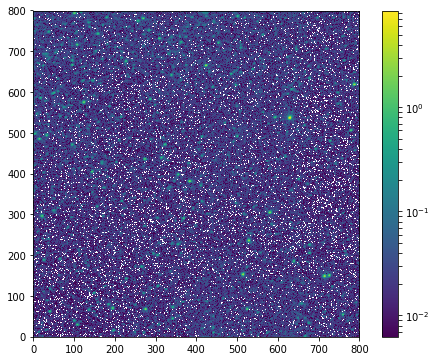

In [2]:
# Load a GALEX LMC/SMC image
galex_lmc_file = fits.open(datadir+'/LMC_CORE_44-nd-int.fits')
galex_lmc_image = galex_lmc_file[0].data
galex_lmc_file.close()

# Grab a square slice from within the image, make a nice 800x800 square to work with
galex_lmc_image = galex_lmc_image[1400:2200,1400:2200]

from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.imshow(galex_lmc_image, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


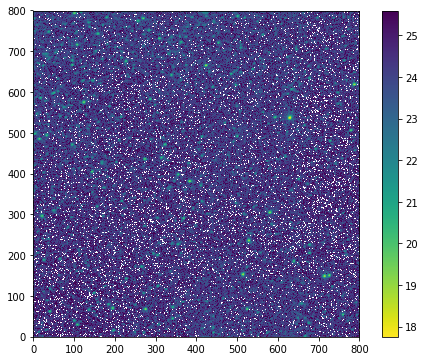

In [3]:
# Convert GALEX count rates to AB magnitude per pixel
# From https://asd.gsfc.nasa.gov/archive/galex/FAQ/counts_background.html
#FUV: mAB = -2.5 x log10(CPS) + 18.82
nuv_zp = 20.08 
nuv_ab = (-2.5 * np.log10(galex_lmc_image) + nuv_zp) * u.ABmag

plt.figure(figsize=(8,6))
plt.imshow(nuv_ab.value, cmap='viridis_r', aspect=1, origin='lower')
plt.colorbar()

In [4]:
# Pass through Marianne's code to get DUET magnitudes per pixel
# Only really applies to fields with NUV and FUV, and we only have NUV of the most crowded fields
# So let's skip this step for now...

# Convert AB magnitudes back to DUET count rates using utils
fluence1 = duet_abmag_to_fluence(nuv_ab, duet.bandpass1)
fluence2 = duet_abmag_to_fluence(nuv_ab, duet.bandpass2)

duet_countrate1 = duet.trans_eff * duet.eff_area * fluence1
duet_countrate2 = duet.trans_eff * duet.eff_area * fluence2

# Deconvolve with GALEX PSF, convolve DUET the PSF, with pixel size equal to GALEX
galex_pixel_size = 1.5 * u.arcsec
psf_kernel = duet.psf_model(pixel_size = galex_pixel_size)
psf_image1 = convolve(duet_countrate1, psf_kernel) * duet_countrate1.unit
psf_image2 = convolve(duet_countrate2, psf_kernel) * duet_countrate2.unit

psf_image1 = duet_countrate1
psf_image2 = duet_countrate2

# Bin up by four to approximate DUET pixel size
shape = (galex_lmc_image.shape[0] // 4, 4, galex_lmc_image.shape[1] // 4, 4)
binned_image1 = psf_image1.reshape(shape).sum(-1).sum(1)
binned_image2 = psf_image2.reshape(shape).sum(-1).sum(1)

# Convert to counts and add noise
counts1 = binned_image1 * exposure
counts2 = binned_image2 * exposure

noise1 = np.random.poisson(counts1.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts1.shape)
duet_image1 = np.floor(noise1) * counts1.unit
duet_image1[duet_image1 < 0] = 0

noise2 = np.random.poisson(counts2.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts2.shape)
duet_image2 = np.floor(noise2) * counts2.unit
duet_image2[duet_image2 < 0] = 0

# Number of exposures for a reference image
n_exp = 5

ref1, ref2 = np.zeros(counts1.shape) * counts1.unit, np.zeros(counts2.shape) * counts2.unit
for i in range(n_exp):
    # Apply Poisson noise and instrument noise
    r1 = np.random.poisson(counts1.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts1.shape)
    r1 = np.floor(r1) * counts1.unit
    r1[r1 < 0] = 0
    
    r2 = np.random.poisson(counts2.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts2.shape)
    r2 = np.floor(r2) * counts2.unit
    r2[r2 < 0] = 0

    # Add to the co-add
    ref1 += r1
    ref2 += r2
ref_rate1 = ref1 / (exposure * n_exp)
ref_rate2 = ref2 / (exposure * n_exp)

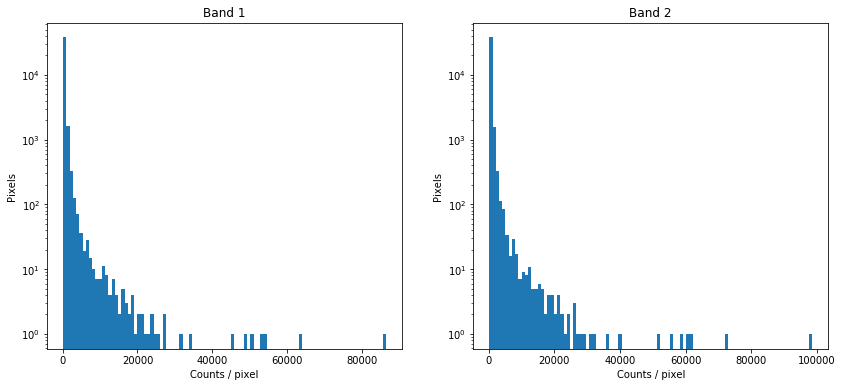

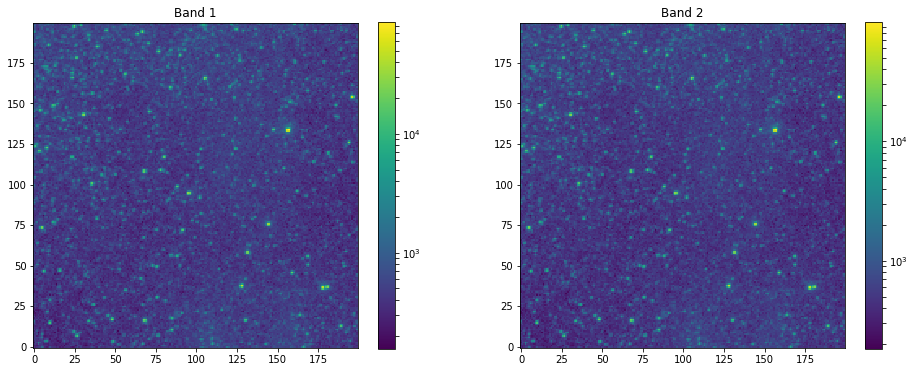

In [5]:
# Values histogram
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.semilogy()
plt.xlabel('Counts / pixel')
plt.ylabel('Pixels')
plt.title('Band 1')
plt.hist(duet_image1.value.flatten(),bins=100)
plt.subplot(122)
plt.semilogy()
plt.xlabel('Counts / pixel')
plt.ylabel('Pixels')
plt.title('Band 2')
plt.hist(duet_image2.value.flatten(),bins=100)

# Images
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Band 1')
plt.imshow(duet_image1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.subplot(122)
plt.title('Band 2')
plt.imshow(duet_image2.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()

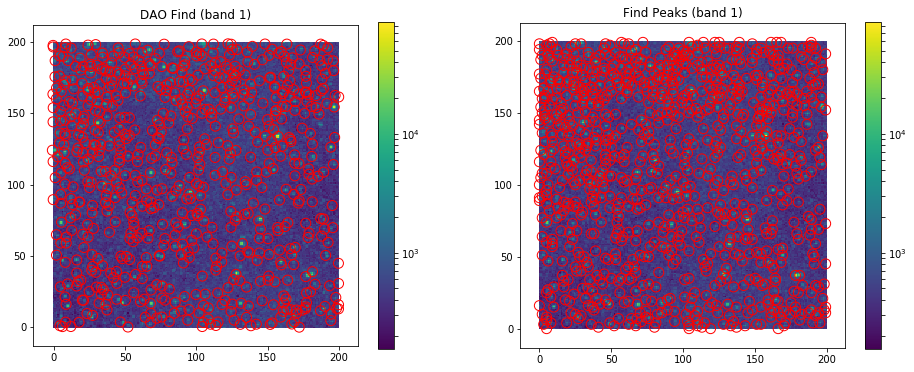

In [7]:
# Run source finding
psf_fwhm = duet.calc_psf_fwhm() 
psf_fwhm_pix = psf_fwhm / duet.pixel

star_tbl_daophot1, bkg_image1, threshold1 = find(duet_image1.value,psf_fwhm_pix.value,method='daophot')
star_tbl_peaks1, _, _ = find(duet_image1.value,psf_fwhm_pix.value,method='peaks')

star_tbl_daophot2, _, threshold2 = find(duet_image2.value,psf_fwhm_pix.value,method='daophot')

# Note - background estimation is being done from the image itself 
# so naturally this is not going to find faint stars on a first pass

# Plot
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('DAO Find (band 1)')
plt.imshow(duet_image1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(star_tbl_daophot1['x'],star_tbl_daophot1['y'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.subplot(122)
plt.title('Find Peaks (band 1)')
plt.imshow(duet_image1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(star_tbl_peaks1['x'],star_tbl_peaks1['y'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)

In [8]:
# Photometry using DAOPhot

# Convert to count rate
duet_image_rate1, duet_image_rate2 = duet_image1 / exposure, duet_image2 / exposure

# Run PSF-fitting photometry
result1, residual_image1 = run_daophot(duet_image_rate1.value,threshold1,star_tbl_daophot1,niters=1,duet=duet)
result2, residual_image2 = run_daophot(duet_image_rate2.value,threshold2,star_tbl_daophot2,niters=1,duet=duet)

print("Band 1: {} sources found. Band 2: {} sources found.".format(len(result1),len(result2)))

#print(result1['x_fit','y_fit','flux_fit','flux_unc'])
#print(result2['x_fit','y_fit','flux_fit','flux_unc'])


PSF-fitting complete


PSF-fitting complete
Band 1: 708 sources found. Band 2: 703 sources found.


(-10, 210)

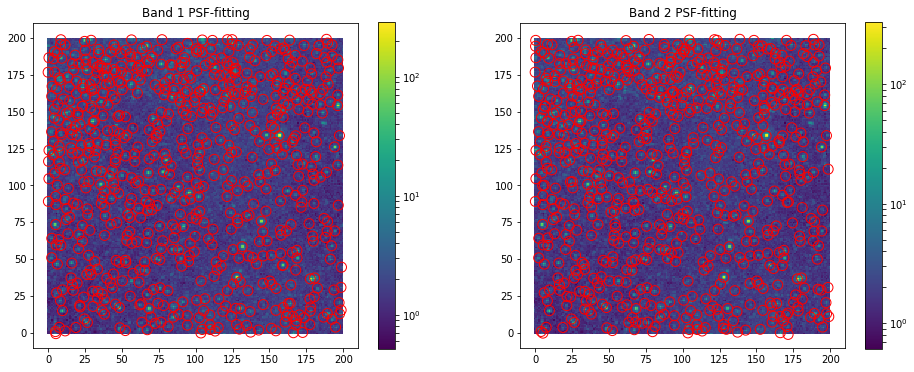

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Band 1 PSF-fitting')
plt.imshow(duet_image_rate1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(result1['x_fit'],result1['y_fit'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.xlim(-10,210)
plt.ylim(-10,210)
plt.subplot(122)
plt.title('Band 2 PSF-fitting')
plt.imshow(duet_image_rate2.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(result2['x_fit'],result2['y_fit'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.xlim(-10,210)
plt.ylim(-10,210)

In [10]:
# Count rates to fluences to magnitudes
duet_fluences1 = result1['flux_fit'] * duet_image_rate1.unit / (duet.trans_eff * duet.eff_area)
duet_mag1 = duet_fluence_to_abmag(duet_fluences1,duet.bandpass1)

duet_fluences2 = result2['flux_fit'] * duet_image_rate2.unit / (duet.trans_eff * duet.eff_area)
duet_mag2 = duet_fluence_to_abmag(duet_fluences2,duet.bandpass2)

print(np.amax(result1['flux_fit']))
print(np.nanmin(duet_mag1))

1831.240925499319
13.677849920635587 mag(AB)


/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


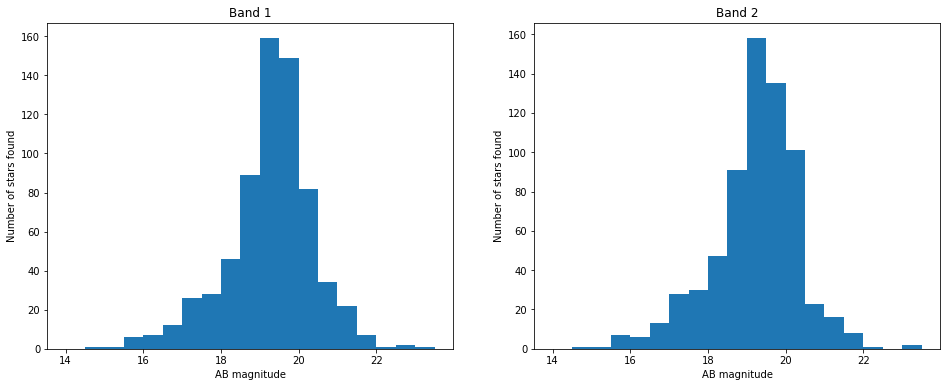

In [11]:
# Plot histogram of sources found
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 1')
plt.hist(duet_mag1, bins=np.arange(14,24,0.5), range=(14,24))
plt.subplot(122)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 2')
plt.hist(duet_mag2, bins=np.arange(14,24,0.5), range=(14,24))
plt.show()

PSF-fitting complete


PSF-fitting complete
5 exposures. Band 1: 713 sources found. Band 2: 718 sources found.


/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


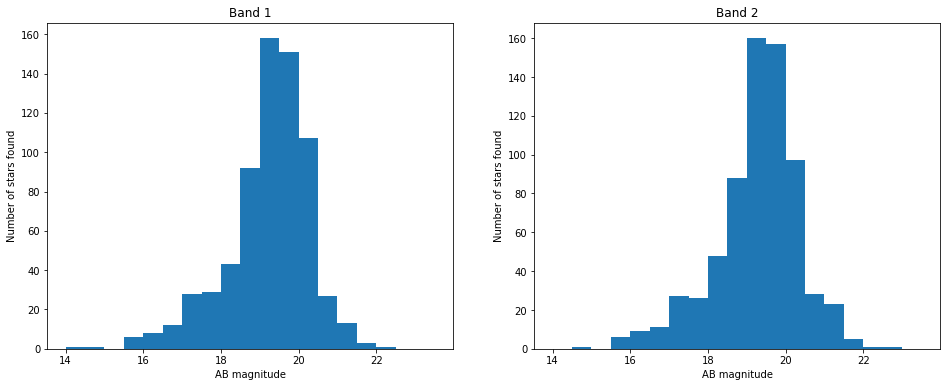

In [12]:
# Does this change for a 'reference image'?
ref_tbl1, _, threshold1 = find(ref_rate1.value,psf_fwhm_pix.value,method='daophot')
ref_tbl2, _, threshold2 = find(ref_rate2.value,psf_fwhm_pix.value,method='daophot')

ref_result1, _ = run_daophot(ref_rate1.value,threshold1,ref_tbl1,niters=1,duet=duet)
ref_result2, _ = run_daophot(ref_rate2.value,threshold2,ref_tbl2,niters=1,duet=duet)

ref_fluences1 = ref_result1['flux_fit'] * ref_rate1.unit / (duet.trans_eff * duet.eff_area)
ref_mag1 = duet_fluence_to_abmag(ref_fluences1,duet.bandpass1)

ref_fluences2 = ref_result2['flux_fit'] * ref_rate2.unit / (duet.trans_eff * duet.eff_area)
ref_mag2 = duet_fluence_to_abmag(ref_fluences2,duet.bandpass2)

print("{} exposures. Band 1: {} sources found. Band 2: {} sources found.".format(n_exp, len(ref_result1), len(ref_result2)))

# Plot histogram of sources found
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 1')
plt.hist(ref_mag1, bins=np.arange(14,24,0.5), range=(14,24))
plt.subplot(122)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 2')
plt.hist(ref_mag2, bins=np.arange(14,24,0.5), range=(14,24))
plt.show()

In [13]:
# Next, fake star tests. This bit takes a while.

# Set up general parameters
n_exp = 5
psf_kernel = duet.psf_model(pixel_size = 6 * u.arcsec, x_size=5, y_size=5) # The GALEX bin-up by 4 is approximate
mag_diff = 0.1 # What magnitude difference do we want to measure?

# for mag in range(18,23):
mag = 18
num_stars = 50
mags = [mag]*num_stars * u.ABmag
mag_diffs = [mag-mag_diff]*num_stars * u.ABmag

# Generate 50 fake stars
x, y = np.random.randint(low=0,high=200,size=num_stars), np.random.randint(low=0,high=200,size=num_stars)
crs1 = duet.trans_eff * duet.eff_area * duet_abmag_to_fluence(mags, duet.bandpass1)
cr_diffs1 = duet.trans_eff * duet.eff_area * duet_abmag_to_fluence(mag_diffs, duet.bandpass1)
crs2 = duet.trans_eff * duet.eff_area * duet_abmag_to_fluence(mags, duet.bandpass2)
cr_diffs2 = duet.trans_eff * duet.eff_area * duet_abmag_to_fluence(mag_diffs, duet.bandpass2)

# Get the actual flux difference
cr_diff1, cr_diff2 = cr_diffs1 - crs1, cr_diffs2 - crs2

PSF-fitting complete


PSF-fitting complete


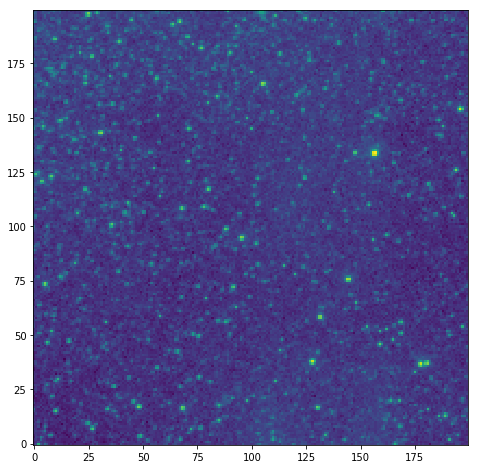

In [15]:
# Create reference image with fake stars
fake_stars1 = np.zeros(counts1.shape) * crs1.unit
fake_stars1[y, x] = crs1
fake_stars1 = convolve(fake_stars1, psf_kernel) * u.ph / u.s

fake_stars2 = np.zeros(counts2.shape) * crs2.unit
fake_stars2[y, x] = crs2
fake_stars2 = convolve(fake_stars2, psf_kernel) * u.ph / u.s

all_stars_counts1, all_stars_counts2 = counts1 + (fake_stars1 * exposure), counts2 + (fake_stars2 * exposure)

ref1, ref2 = np.zeros(all_stars_counts1.shape) * counts1.unit, np.zeros(all_stars_counts2.shape) * counts2.unit
for i in range(n_exp):
    # Apply Poisson noise and instrument noise
    r1 = np.random.poisson(all_stars_counts1.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts1.shape)
    r1 = np.floor(r1) * counts1.unit
    r1[r1 < 0] = 0
    
    r2 = np.random.poisson(all_stars_counts2.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts2.shape)
    r2 = np.floor(r2) * counts2.unit
    r2[r2 < 0] = 0

    # Add to the co-add
    ref1 += r1
    ref2 += r2
    
fake_ref_rate1 = ref1 / (exposure * n_exp)
fake_ref_rate2 = ref2 / (exposure * n_exp)

plt.figure(figsize=(8,8))
plt.imshow(fake_ref_rate1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())

# Can we find/measure the fake stars?
fake_ref_tbl1, _, threshold1 = find(fake_ref_rate1.value,psf_fwhm_pix.value,method='daophot')
fake_ref_tbl2, _, threshold2 = find(fake_ref_rate2.value,psf_fwhm_pix.value,method='daophot')

fake_ref_result1, _ = run_daophot(fake_ref_rate1.value,threshold1,fake_ref_tbl1,niters=1,duet=duet)
fake_ref_result2, _ = run_daophot(fake_ref_rate2.value,threshold2,fake_ref_tbl2,niters=1,duet=duet)

/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


Reference sources found: 50, 50


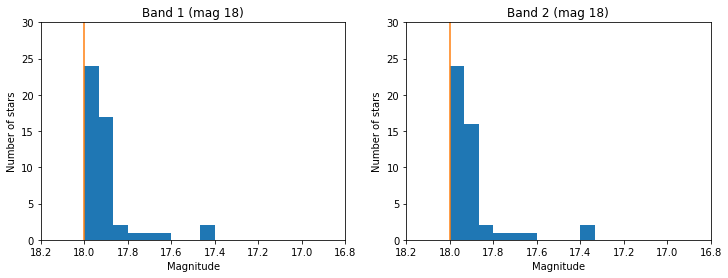

In [16]:
# Generate fluences, mags for the fake-star results
fake_ref_result1['fluence_fit'] = fake_ref_result1['flux_fit'] * fake_ref_rate1.unit / (duet.trans_eff * duet.eff_area)
fake_ref_result1['fluence_unc'] = fake_ref_result1['flux_unc'] * fake_ref_rate1.unit / (duet.trans_eff * duet.eff_area)
fake_ref_result1['mag_fit'] = duet_fluence_to_abmag(fake_ref_result1['fluence_fit'].quantity, duet.bandpass1)

fake_ref_result2['fluence_fit'] = fake_ref_result2['flux_fit'] * fake_ref_rate2.unit / (duet.trans_eff * duet.eff_area)
fake_ref_result2['fluence_unc'] = fake_ref_result2['flux_unc'] * fake_ref_rate2.unit / (duet.trans_eff * duet.eff_area)
fake_ref_result2['mag_fit'] = duet_fluence_to_abmag(fake_ref_result2['fluence_fit'].quantity, duet.bandpass2)

# For each star, find nearest in the fit results
mag_measured1, mag_measured2 = np.zeros(num_stars) * u.ABmag, np.zeros(num_stars) * u.ABmag
for i in range(num_stars):
    sep1 = np.sqrt((x[i] - fake_ref_result1['x_fit'])**2 + (y[i] - fake_ref_result1['y_fit'])**2)
    nearest1 = fake_ref_result1[sep1.argmin()]
    
    if sep1.min() < 1: # Some small value - just to keep only genuine matches
        mag_measured1[i] = nearest1['mag_fit'] * u.ABmag
        
    sep2 = np.sqrt((x[i] - fake_ref_result2['x_fit'])**2 + (y[i] - fake_ref_result2['y_fit'])**2)
    nearest2 = fake_ref_result2[sep2.argmin()]
    if sep2.min() < 1:
        mag_measured2[i] = nearest2['mag_fit'] * u.ABmag

mag_accuracy1 = mags - mag_measured1
mag_accuracy2 = mags - mag_measured2
print("Reference sources found: {}, {}".format(len(mag_accuracy1[mag_accuracy1 < mag * u.mag]),
                                               len(mag_accuracy2[mag_accuracy2 < mag * u.mag])))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.xlabel('Magnitude')
plt.ylabel('Number of stars')
plt.title('Band 1 (mag {})'.format(mag))
plt.hist(mag_measured1[mag_accuracy1 < mag * u.mag].value,range=(mag-1,mag+1),bins=30)
plt.plot([mag,mag],[0,40])
plt.xlim([mag+0.2,mag-1.2])
plt.ylim([0,30])
plt.subplot(122)
plt.xlabel('Magnitude')
plt.ylabel('Number of stars')
plt.title('Band 2 (mag {})'.format(mag))
plt.hist(mag_measured2[mag_accuracy2 < mag * u.mag].value,range=(mag-1,mag+1),bins=30)
plt.plot([mag,mag],[0,40])
plt.xlim([mag+0.2,mag-1.2])
plt.ylim([0,30])
plt.show()

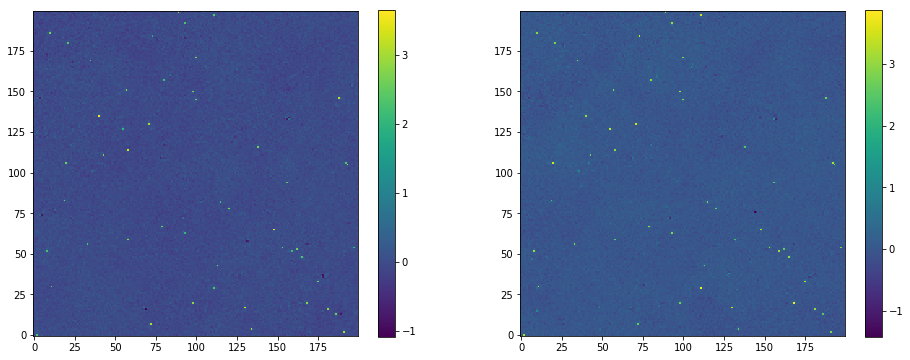

In [18]:
# Create exposure image with fake stars 
fake_stars_im1 = np.zeros(counts1.shape) * cr_diffs1.unit
fake_stars_im1[y, x] = cr_diffs1
fake_stars_im1 = convolve(fake_stars_im1, psf_kernel) * u.ph / u.s

fake_stars_im2 = np.zeros(counts2.shape) * cr_diffs2.unit
fake_stars_im2[y, x] = cr_diffs2
fake_stars_im2 = convolve(fake_stars_im2, psf_kernel) * u.ph / u.s

counts_im1, counts_im2 = counts1 + (fake_stars_im1 * exposure), counts2 + (fake_stars_im2 * exposure)
c1 = np.random.poisson(counts_im1.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts1.shape)
c1 = np.floor(c1) * counts1.unit
c1[c1 < 0] = 0
c2 = np.random.poisson(counts_im2.value) + np.random.normal(loc=0,scale=duet.read_noise,size=counts2.shape)
c2 = np.floor(c2) * counts2.unit
c2[c2 < 0] = 0
fake_im_rate1, fake_im_rate2 = c1 / exposure, c2 / exposure

# Create difference images
psf = psf_kernel.array
dx, dy = 1,1

image_bkg1, image_bkg_rms_median1 = estimate_background(fake_im_rate1.value)
ref_bkg1, ref_bkg_rms_median1 = estimate_background(fake_ref_rate1.value)
fake_im_rate_bkgsub1, fake_ref_rate_bkgsub1 = fake_im_rate1 - image_bkg1*u.ph/u.s, fake_ref_rate1 - ref_bkg1*u.ph/u.s
s_n, s_r = np.sqrt(fake_im_rate1), np.sqrt(fake_ref_rate1)
sn, sr = np.mean(s_n), np.mean(s_r)
fake_diff1, d_psf1, s_corr1 = py_zogy(fake_im_rate_bkgsub1,fake_ref_rate_bkgsub1,psf,psf,s_n,s_r,sn,sr,dx,dy)

image_bkg2, image_bkg_rms_median2 = estimate_background(fake_im_rate2.value)
ref_bkg2, ref_bkg_rms_median2 = estimate_background(fake_ref_rate2.value)
fake_im_rate_bkgsub2, fake_ref_rate_bkgsub2 = fake_im_rate2 - image_bkg2*u.ph/u.s, fake_ref_rate2 - ref_bkg2*u.ph/u.s
s_n, s_r = np.sqrt(fake_im_rate2), np.sqrt(fake_ref_rate2)
sn, sr = np.mean(s_n), np.mean(s_r)
fake_diff2, d_psf2, s_corr2 = py_zogy(fake_im_rate_bkgsub2,fake_ref_rate_bkgsub2,psf,psf,s_n,s_r,sn,sr,dx,dy)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(fake_diff1.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_diff2.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
# 

# For a range of magnitudes:
# Create a) a 'reference' image containing ~50 fake stars
# - question: can we detect all of these stars?
# - question: to what accuracy do we measure their magnitude?
# b) an exposure of the same fake stars with a change in magnitude
# - question: can we detect all of these changes?
# - to what accuracy etc.?

In [19]:
# Do find/photometry on the difference images
fake_diff_tbl1, _, threshold1 = find(fake_diff1.value,psf_fwhm_pix.value,method='daophot')
fake_diff_tbl2, _, threshold2 = find(fake_diff2.value,psf_fwhm_pix.value,method='daophot')

fake_diff_result1, _ = run_daophot(fake_diff1.value,threshold1,fake_diff_tbl1,niters=1,duet=duet)
fake_diff_result2, _ = run_daophot(fake_diff2.value,threshold2,fake_diff_tbl2,niters=1,duet=duet)

PSF-fitting complete


PSF-fitting complete


Difference image sources found: 49, 49


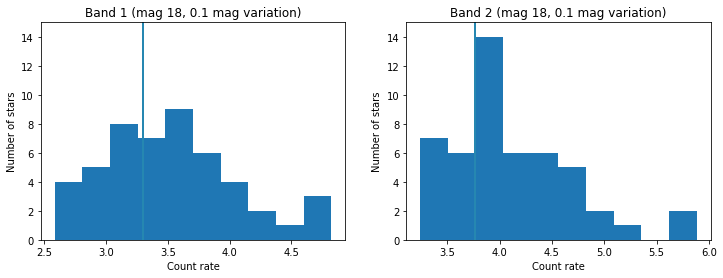

(-10, 210)

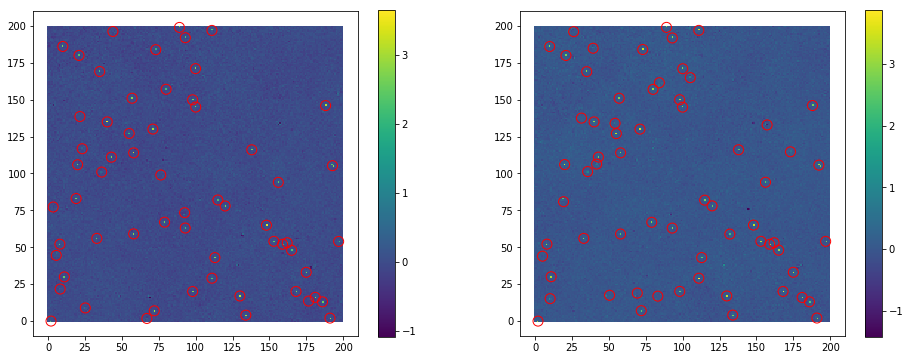

In [21]:
# For each star, again find nearest in the fit results
diff_measured1, diff_measured2 = np.zeros(num_stars) * u.ph / u.s, np.zeros(num_stars)  * u.ph / u.s
for i in range(num_stars):
    sep1 = np.sqrt((x[i] - fake_diff_result1['x_fit'])**2 + (y[i] - fake_diff_result1['y_fit'])**2)
    nearest1 = fake_diff_result1[sep1.argmin()]

    if sep1.min() < 1: # Some small value - just to keep only genuine matches
        diff_measured1[i] = nearest1['flux_fit'] * u.ph / u.s
        
    sep2 = np.sqrt((x[i] - fake_diff_result2['x_fit'])**2 + (y[i] - fake_diff_result2['y_fit'])**2)
    nearest2 = fake_diff_result2[sep2.argmin()]
    if sep2.min() < 1:
        diff_measured2[i] = nearest2['flux_fit'] * u.ph / u.s
        
diff_accuracy1, diff_accuracy2 = cr_diff1 - diff_measured1, cr_diff2 - diff_measured2
print("Difference image sources found: {}, {}".format(len(diff_accuracy1[diff_accuracy1 < cr_diff1]),
                                                      len(diff_accuracy2[diff_accuracy2 < cr_diff2])))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.xlabel('Count rate')
plt.ylabel('Number of stars')
plt.title('Band 1 (mag {}, {} mag variation)'.format(mag, mag_diff))
plt.hist(diff_measured1[diff_accuracy1 < cr_diff1].value)
plt.plot([cr_diff1,cr_diff1],[0,15])
plt.ylim(0,15)
plt.subplot(122)
plt.xlabel('Count rate')
plt.ylabel('Number of stars')
plt.title('Band 2 (mag {}, {} mag variation)'.format(mag, mag_diff))
plt.hist(diff_measured2[diff_accuracy2 < cr_diff2].value)
plt.plot([cr_diff2,cr_diff2],[0,15])
plt.ylim(0,15)
plt.show()


plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(fake_diff1.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(fake_diff_result1['x_fit'],fake_diff_result1['y_fit'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.xlim(-10,210)
plt.ylim(-10,210)
plt.subplot(122)
plt.imshow(fake_diff2.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(fake_diff_result2['x_fit'],fake_diff_result2['y_fit'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.xlim(-10,210)
plt.ylim(-10,210)

In [ ]:
'''
    In progress - trying to figure out how to build a fittable PSF like the DUET one

    # astropy fittable model based on the two Gaussians. Possibly this should go in config?
    sig = duet.psf_params['sig']
    amp = duet.psf_params['amp']
    
    duet_psf = duet.psf_model()
    
    psf_model = IntegratedGaussianPRF(flux=flux1, sigma=sig[0]) + IntegratedGaussianPRF(flux=flux2, sigma=sig[1])
   
    print(star_tbl.columns)
    
'''